In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix

# Домашнее задание №3

Решенный ноутбук нужно загрузить в [форму](http://bit.ly/dafe_hw)  
Дедлайн: __22.05.2019__

## Загрузка данных (5%)

In [126]:
lfw_people = datasets.fetch_lfw_people(
    min_faces_per_person=50, 
    resize=0.4)

Выведите:
- кол-во объектов
- Кол-во признаков
- кол-во классов
- посмотрите, сколько изображений соответствет каждому классу
- Отрисуйте изображения для случайных семплов с подписями имен класса 

кол-во объектов 1560
Кол-во признаков 1850
кол-во классов 12
{0: 77, 1: 236, 2: 121, 3: 530, 4: 109, 5: 71, 6: 52, 7: 55, 8: 53, 9: 60, 10: 52, 11: 144}


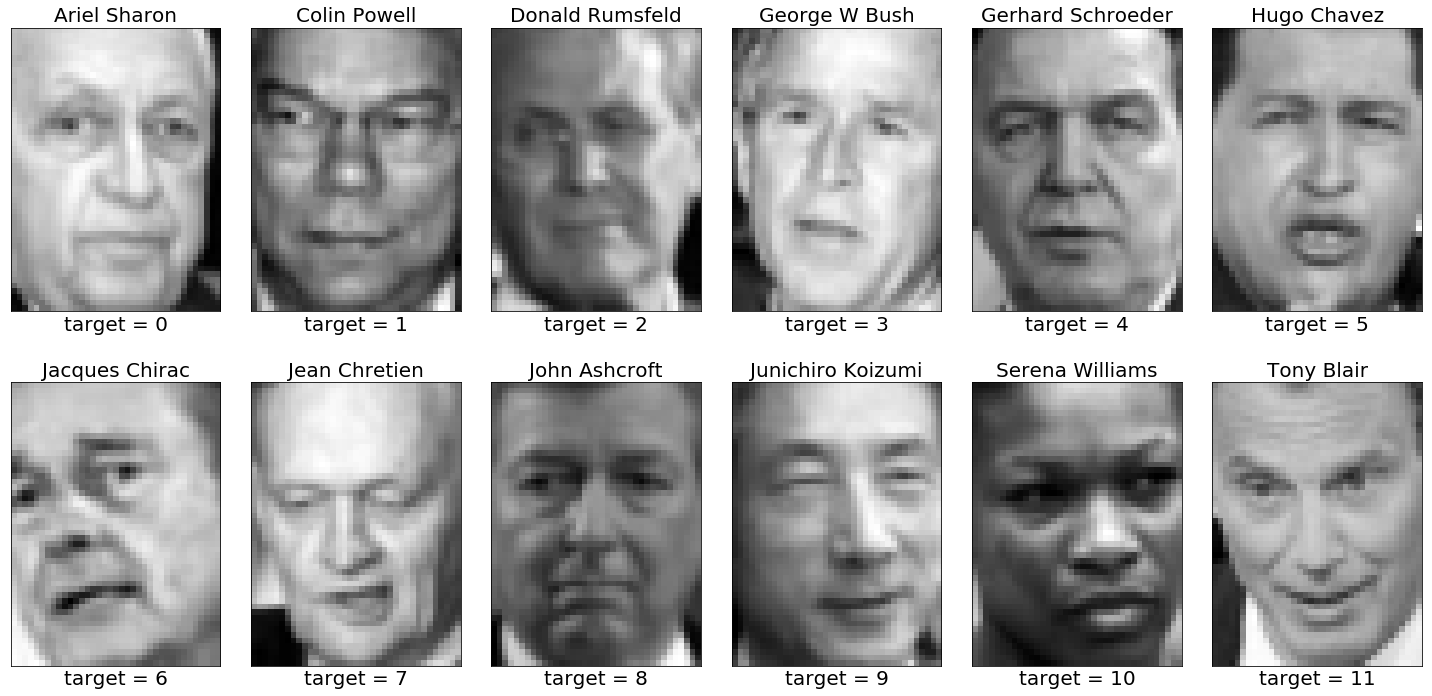

In [123]:
# Ваш код здесь
print('кол-во объектов', lfw_people.data.shape[0])
print('Кол-во признаков', lfw_people.data.shape[1])
num_classes = len(set(lfw_people.target))
print('кол-во классов', num_classes)
unique, counts = np.unique(lfw_people.target, return_counts=True)
print(dict(zip(unique, counts)))

pic_to_idx = {idx:i for i, idx in enumerate(lfw_people.target)}

fig, ax = plt.subplots(nrows = 2, ncols = 6, figsize=(20, 10))
ax = ax.ravel(order='C')
for i in range(num_classes):
    ax[i].imshow(lfw_people.images[pic_to_idx.get(i)], cmap='gray')
    ax[i].set_title(lfw_people.target_names[i], fontsize=20)
    ax[i].set_xlabel('target = {}'.format(i), fontsize=20)
    ax[i].set_xticks([])
    ax[i].set_yticks([])
    
plt.tight_layout()
plt.show()

## Пора учить нейронки! (5%) 

In [124]:
from keras.models import Sequential 
from keras.layers import Dense, Flatten, Activation, Conv2D, MaxPooling2D, Dropout 
from keras.utils import np_utils
from keras.optimizers import Adam

Using TensorFlow backend.


In [158]:
# Конечно мы сначала должны нормировать и центрировать данные: 
mean, std = lfw_people.data.mean(), lfw_people.data.std()
x = (lfw_people.data - mean) / std
y = lfw_people.target

# используйте lfw_people.target и lfw_people.images

In [159]:
def indices_to_one_hot(data, nb_classes):
    """one-hot-encoding"""
    targets = np.array(data).reshape(-1)
    return np.eye(nb_classes)[targets]

y_ohe = indices_to_one_hot(y, num_classes)

In [160]:
# Разделим данные на трейн/валидацию/тест: 
x_train, x_test, y_train_cat, y_test_cat = train_test_split(x, y_ohe, train_size=0.6, test_size=0.4, random_state=42)
x_val, x_test, y_val_cat, y_test_cat = train_test_split(x_test, y_test_cat, train_size=0.5, test_size=0.5, random_state=42)

# Cделайте one-hot-encoding длgithя целевой переменной

def indices_from_one_hot(data):
    """one-hot-decoding"""
    return np.array([np.where(target == 1.)[0][0] for target in data])

## Fully connected neural network (20%)
Создадим нашу первую модель, будем использовать полносвязную нейронную сеть 
- Первый слой (входной): 64 нейрона, функция активации ReLU
- Скрытый слой: 32 нейрона, функция активации ReLU
- Чтобы наша сеть не переобучалась, после каждого полно-связного используйте слой Dropout с параметром rate = 0.4
- Выходной слой: на ваше усмотрение :) 

Будем обучать с помощью Adam на 100 эпохах,  размер сэмпла для минибатча: 10

Учимся на train, валидируем на val

Постройте confusion_matrix (используйте sklearn) на тестовой выборке (test) и посчитайте долю правильных ответов(test)

In [ ]:
confusionmatrix = # Ваш код здесь

plt.figure(figsize=(12, 6))
sns.heatmap(confusionmatrix, cmap='Greens', annot=True,
            xticklabels=lfw_people.target_names,
            yticklabels=lfw_people.target_names)
plt.show()

Оцените, кого с кем вы чаще всего путаете? Почему одних людей наша сеть путает с другими чаще?

Вспомним, что в нашей задачи классы, не сбалансированы, какая получится доля правильных ответов, если мы всегда будем предсказывать константнам значением: George W Bush

In [ ]:
# Ваш код здесь

## Это же картинки! Попробуем Convolution neural network (30%)

- Используйте два сверточных слоя (по 16 нейронов с функцией активации ReLu, padding='same')
- Затем слой MaxPooling'a с размерром 2х2
- Затем полносвязные слои: 32 нейрона и 16 нейронов
- Выходной слой как раньше 

Помните о требованиях свертки к размерности входных данных и используйте `.reshape`

In [ ]:
# Ваш код здесь

Постройте confusion_matrix (используйте sklearn) на тестовой выборке (test) и посчитайте долю правильных ответов(test)

In [ ]:
confusionmatrix = # Ваш код здесь

plt.figure(figsize=(12, 6))
sns.heatmap(confusionmatrix, cmap='Greens', annot=True,
            xticklabels=lfw_people.target_names,
            yticklabels=lfw_people.target_names)
plt.show()

Кажется, что стало лучше, но постройте график зависимости доли правильных ответов от эпохи на обучении и валидации. Какие выводы можно сделать?  

### Ваши ответы здесь

## Aугментация дынных (40%)
Вспомним, что для борьбы с переобучением, нам может помочь Aугментация, для этого мы будем использовать стандартные возможности Keras. Загляните в [доку](https://keras.io/preprocessing/image/) или в эту [статью](https://towardsdatascience.com/image-augmentation-for-deep-learning-using-keras-and-histogram-equalization-9329f6ae5085) 

Вы можете использовать любые аугментации

In [ ]:
from keras.preprocessing.image import ImageDataGenerator

In [ ]:
# Ваш код здесь

Посмотрите долю правильных ответов на тестовой выборке и постройте график зависимости от эпох для обучения и валидации
Ответьте на вопросы и объясните свой ответ: 
- Удалось ли Вам победить переобучение? 
- Будет ли полезна аугментация horizontal_flip?

### Ваши ответы здесь

## Дополнительное задание (дополнительные +30%) 
Обучите такую нейронную сеть, чтобы на тестовой выборке достичь доли правильных ответов больше 92%

In [ ]:
# Ваш код здесь